In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
import os
from google.colab import drive

**Go to Colab Notebooks in my drive**

In [239]:
!pwd
os.chdir('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code')
!pwd

/content/drive/My Drive/Colab Notebooks/WeaponProject/Code
/content/drive/My Drive/Colab Notebooks/WeaponProject/Code


**imports**

In [0]:
from kerasYolov3  import  yolo_loss,preprocess_true_boxes,yolo_body,get_random_data,yolo_eval
from keras.metrics import categorical_crossentropy
from functools import reduce
import keras.backend as K
import tensorflow as tf
import numpy as np
import time
import cv2

In [0]:
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense,Input, Lambda
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import Sequence,load_model
from keras import backend as K
from PIL import Image 
import matplotlib.pyplot as plt 
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import random 
import colorsys
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

** funct To extarct classes and anchors from the txt file**
"3-CLASSES_test.txt"

**'''loads the classes'''**

In [0]:
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

**'''loads the anchors from a file'''**

In [0]:
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

**'''data generator for fit_generator'''**

In [0]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
  
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)


In [0]:
def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

**create the training model**

In [0]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2, weights_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/model_data/YoloModel.h5'):
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))


        model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [249]:
annotation_path ='/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/3_CLASS_test.txt'
classesFile = '/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/3_CLASS_test._classes.txt'
class_names = get_classes(classesFile)
num_classes = len(class_names)
anchors_path = '/content/drive/My Drive/Colab Notebooks/WeaponProject/model_data/yolo_anchors.txt'
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)
log_dir = 'logs/000/'
input_shape = (416,416) 
print(anchors)
print("____ok__ i have :{} Classes___the input_sahpe is{}____num_anchors:{}".format(num_classes,input_shape,num_anchors))


[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 326.]]
____ok__ i have :3 Classes___the input_sahpe is(416, 416)____num_anchors:9


**Creat the model **

In [279]:
model = create_model(input_shape, anchors, num_classes) 

Create YOLOv3 model with 9 anchors and 3 classes.
Load weights /content/drive/My Drive/Colab Notebooks/WeaponProject/model_data/YoloModel.h5.
Freeze the first 249 layers of total 252 layers.


**Show the Summary**

In [0]:
model.summary()

**Creating checkpoit model**
to save loss and acc after each epoch

**EarlyStopping To stop trining when we got the best rslts during the training**
the goal of this is to to mim the risque of** ouver fiting**

In [0]:
logging = TensorBoard(log_dir=log_dir) #enable visualizations for TensorBoard
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
      monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1) #to reducing the learning rate verbose 1 to  update messages.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [0]:
val_split = 0.1
with open(annotation_path) as f:
        lines = f.readlines()
np.random.shuffle(lines)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

**Compile The Model**

 use custom yolo_loss

In [0]:
model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

**Fit The Model**

In [291]:
batch_size = 32
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
history=model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=500,#max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=300, #max(1, num_val//batch_size),
                epochs=7,
                callbacks=[logging, checkpoint])

Train on 774 samples, val on 86 samples, with batch size 32.
Epoch 1/7
500/500 [==============================] - 2130s 4s/step - loss: 439.9930 - val_loss: 5754.6353
Epoch 2/7
500/500 [==============================] - 2062s 4s/step - loss: 52.1949 - val_loss: 5610.1362
Epoch 3/7
500/500 [==============================] - 2079s 4s/step - loss: 39.1957 - val_loss: 5478.8179
Epoch 4/7
500/500 [==============================] - 2068s 4s/step - loss: 34.9832 - val_loss: 5589.3232
Epoch 5/7
500/500 [==============================] - 2062s 4s/step - loss: 32.7709 - val_loss: 5601.8130
Epoch 6/7
500/500 [==============================] - 2054s 4s/step - loss: 31.2868 - val_loss: 5728.1475
Epoch 7/7
500/500 [==============================] - 2054s 4s/step - loss: 30.5466 - val_loss: 5686.3291


**Save The Model**

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolo_model.h5')

In [0]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolov3_training_last.weights')

**Unfreeze and continue training**

because i got bad resalt of loos so i wll fine-tune the model

In [0]:
for i in range(len(model.layers)):
            model.layers[i].trainable = True

**Compile** the model with my **custom loss function**

In [295]:
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred} ) # recompile to apply the change
print('Unfreeze all of the layers.')

Unfreeze all of the layers.


batch size les then first trinig because that more GPU memory is required after unfreezing the body

In [0]:
   batch_size = 8 

Begin the fine-tuning

In [297]:
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
history=model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=150, #max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=60, #max(1, num_val//batch_size),
                epochs=12,
                callbacks=[logging, checkpoint, reduce_lr, early_stopping])

Train on 774 samples, val on 86 samples, with batch size 8.
Epoch 1/12
  2/150 [..............................] - ETA: 29:46 - loss: 34.5963

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.626802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/150 [==============================] - 171s 1s/step - loss: 28.6111 - val_loss: 33.2156
Epoch 2/12
150/150 [==============================] - 147s 980ms/step - loss: 27.7820 - val_loss: 32.5401
Epoch 3/12
150/150 [==============================] - 147s 983ms/step - loss: 26.3469 - val_loss: 53.6026
Epoch 4/12
150/150 [==============================] - 147s 981ms/step - loss: 25.9427 - val_loss: 25.9252
Epoch 5/12
150/150 [==============================] - 147s 978ms/step - loss: 25.7625 - val_loss: 28.0783
Epoch 6/12
150/150 [==============================] - 147s 979ms/step - loss: 25.3328 - val_loss: 32.8744
Epoch 7/12
150/150 [==============================] - 147s 979ms/step - loss: 24.9324 - val_loss: 49.2051

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 8/12
150/150 [==============================] - 146s 975ms/step - loss: 25.1029 - val_loss: 19.7143
Epoch 9/12
150/150 [==============================] - 147s 978ms/step - loss: 24.0425

**Save the finael Model**

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolo_model.h5')

In [0]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolov3_training_last.weights')

**Plot loss resalts**

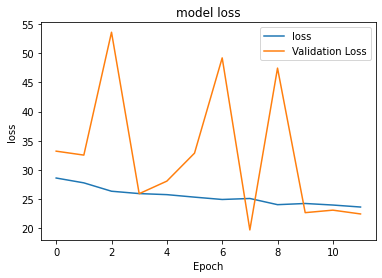

In [305]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

Generate Test data with **Imagedatagenerator**

In [301]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dirr='/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/test/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(    
        test_dirr,
        target_size=(224, 224), 
       classes=class_names,
       batch_size=10,
        class_mode='categorical')

Found 80 images belonging to 3 classes.


get X_test and y_test from image data gen

In [302]:
X_test, y_test = test_generator.next()
print(y_test.shape)


(10, 3)


i will evaliate my model with valdiation data like test data bcs i dot use it in the trining to rise the err of input model demenssion

In [0]:
model.evaluate(X_test,y_test,verbose=1)
print("Train and test mAP:",mAP)

**Path to saved model  weights and cfg file**

In [0]:
model_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolo_model.h5'
weights_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolov3_training_last.weights'
cfg='/content/drive/My Drive/Colab Notebooks/WeaponProject/model_data/yolov3.cfg'
test_cfg='/content/drive/My Drive/Colab Notebooks/WeaponProject/model_data/yolov3_testing.cfg'

**load and build the model** for the evaliuation

In [331]:
try:
            model = load_model(model_path, compile=False)
except:
            model=yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            model.load_weights(weights_path) 
      
print('{} model, anchors, and classes loaded.'.format(model_path))

/content/drive/My Drive/Colab Notebooks/WeaponProject/Code/yolo_model.h5 model, anchors, and classes loaded.


**Test**

In [0]:
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

In [0]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

In [0]:
def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)
   
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

In [0]:
def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)


In [0]:
def draw_bbox(image, bboxes, CLASSES=class_names, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors=''):   
    NUM_CLASS =class_names
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else "" 
            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

In [0]:
def detect_image(YoloV3, image_path, output_path, input_size=416, CLASSES=class_names, score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
   # original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = tf.expand_dims(image_data, 0)

    pred_bbox = YoloV3.predict(image_data,steps=8)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    bboxes = nms(bboxes, iou_threshold, method='nms')

    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    if output_path != '': cv2.imwrite(output_path, image)
    return image

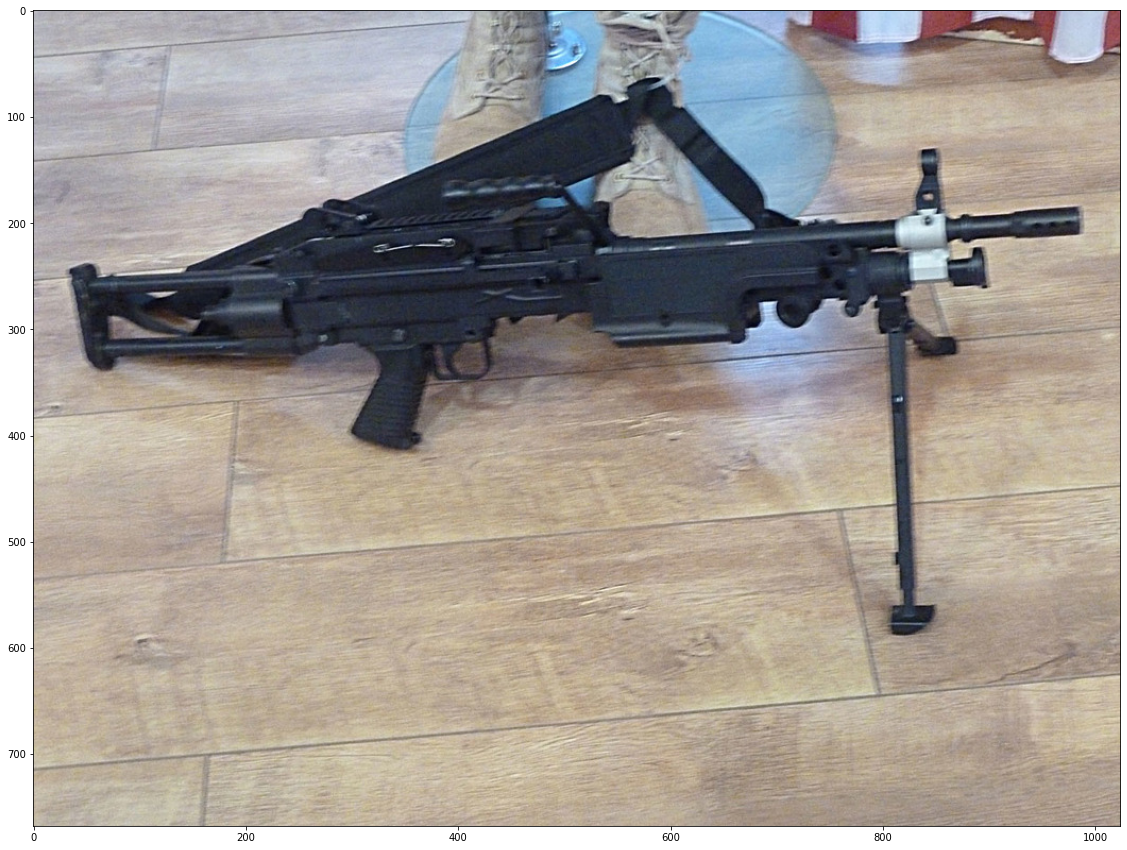

In [0]:
image_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/test/Rifle/26ea34575d7faa54.jpg'
output_im_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/imagetest.jpg'
image = detect_image(model, image_path, output_im_path, input_size=416, CLASSES=class_names, rectangle_colors=(255,0,0))
plt.figure(figsize=(30,15))
plt.imshow(image)

**detect_video**

In [0]:
def detect_video(YoloV3, video_path, output_path, input_size=416, CLASSES=class_names, score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):
    times = []
    vid = cv2.VideoCapture(video_path)

    # by default VideoCapture returns float instead of int
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    codec = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, codec, fps, (width, height)) # output_path must be .mp4

    while True:
        _, img = vid.read()

        try:
            original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        except:
            break
        image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
        image_data = tf.expand_dims(image_data, 0)
        
        t1 = time.time()
        pred_bbox = YoloV3.predict(image_data,steps=32)
        t2 = time.time()
        
        pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
        pred_bbox = tf.concat(pred_bbox, axis=0)

        bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
        bboxes = nms(bboxes, iou_threshold, method='nms')
        
        times.append(t2-t1)
        times = times[-20:]
        print("Time: {:.2f}ms".format(sum(times)/len(times)*1000))

        image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
        image = cv2.putText(image, "Time: {:.2f}ms".format(sum(times)/len(times)*1000), (0, 30),
                          cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)

        if output_path != '': out.write(image)

    cv2.destroyAllWindows()

In [0]:
video_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/20200530_212803.mp4'
output_vid_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/2.mp4'
detect_video(model, video_path,output_vid_path, input_size=416, rectangle_colors=(255,0,0))

Time: 996.97ms
Time: 1003.36ms
Time: 1006.71ms
Time: 1003.14ms
Time: 1004.40ms
Time: 1004.68ms
Time: 1005.87ms
Time: 1005.05ms
Time: 1005.56ms
Time: 1004.91ms
Time: 1005.00ms
Time: 1004.89ms
Time: 1004.62ms
Time: 1004.05ms
Time: 1003.69ms
Time: 1003.31ms
Time: 1003.64ms
Time: 1003.35ms
Time: 1003.01ms
Time: 1003.10ms
Time: 1003.57ms
Time: 1003.23ms
Time: 1002.31ms
Time: 1003.37ms
Time: 1003.40ms
Time: 1003.91ms
Time: 1003.81ms
Time: 1004.00ms
Time: 1003.29ms
Time: 1003.26ms
Time: 1003.10ms
Time: 1003.36ms
Time: 1003.60ms
Time: 1003.79ms
Time: 1003.82ms
Time: 1004.22ms
Time: 1003.76ms
Time: 1004.44ms
Time: 1004.70ms
Time: 1005.00ms
Time: 1005.88ms
Time: 1005.98ms
Time: 1006.53ms
Time: 1005.92ms
Time: 1005.65ms
Time: 1005.04ms
Time: 1004.84ms
Time: 1005.19ms
Time: 1005.57ms
Time: 1005.70ms
Time: 1005.22ms
Time: 1004.71ms
Time: 1004.78ms
Time: 1004.87ms
Time: 1005.16ms
Time: 1005.10ms
Time: 1005.53ms
Time: 1005.44ms
Time: 1006.22ms
Time: 1006.24ms
Time: 1006.09ms
Time: 1005.86ms
Time: 100

test2


In [0]:
def image_preporcess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw = int(scale * w)
    nh = int(scale * h)
    
    image_resized = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized

    image_paded = np.array(image_paded, dtype='float32')
    
    image_paded = image_paded / 255.
    
    image_paded = np.expand_dims(image_paded, axis=0)

    return image_paded

In [0]:
    def detect_image(model,image):
        model_image_size=(416, 416)
        boxed_image = image_preporcess(np.copy(image), tuple(reversed(model_image_size)))
        image_data = boxed_image
        
        input_image_shape = K.placeholder(shape=(2, ))
        sc=0.3
        iou =0.45
        out_boxes, out_scores, out_classes = yolo_eval(model.output,anchors,len(class_names),input_image_shape,score_threshold=sc, iou_threshold=iou)
        
        model.input= image_data
        input_image_shape=[image.shape[0], image.shape[1]]

        thickness = (image.shape[0] + image.shape[1]) // 600
        fontScale=1
        ObjectsList = []
        
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = class_names[c]
            box = out_boxes[i] # boxes[i]
            score =out_scores[i]    # scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            #scores = '{:.2f}'.format(score)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))

            mid_h = (bottom-top)/2+top
            mid_v = (right-left)/2+left

            # put object rectangle
            cv2.rectangle(image, (left, top), (right, bottom),colors[c], thickness)

            # get text size
            (test_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, thickness/text_size, 1)

            # put text rectangle
            cv2.rectangle(image, (left, top), (left + test_width, top - text_height - baseline), colors[c], thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (left, top-2), cv2.FONT_HERSHEY_SIMPLEX, thickness/text_size, (0, 0, 0), 1)

            # add everything to list
            ObjectsList.append([top, left, bottom, right, mid_v, mid_h, label, scores])

        return image, ObjectsList

In [0]:
 def detect_img(image):
        image = cv2.imread(image, cv2.IMREAD_COLOR)
        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image_color = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        r_image, ObjectsList =detect_image(model,original_image_color)
        return r_image, ObjectsList

Generate colors for drawing bounding boxes.

In [0]:
hsv_tuples = [(x / len(class_names), 1., 1.)
                      for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),colors))
np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.

In [0]:
sess = tf.compat.v1.Session()
image = '/content/drive/My Drive/Colab Notebooks/WeaponProject/Dataset/test/Rifle/3bf93688cb550b7f.jpg'
r_image, ObjectsList = detect_img(image)
print(ObjectsList)   
plt.imshow(r_image)

In [0]:
wget https://pjreddie.com/media/files/yolov3.weights


**The err when i dont make the step value**

In [0]:
ValueError                                Traceback (most recent call last)
<ipython-input-31-9a58ea2533f0> in <module>()
      1 video_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/me.mp4'
      2 output_vid_path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/viddd.mp4'
----> 3 detect_video(model, video_path,output_vid_path, input_size=416, rectangle_colors=(255,0,0))

3 frames
<ipython-input-28-282899638d20> in detect_video(YoloV3, video_path, output_path, input_size, CLASSES, score_threshold, iou_threshold, rectangle_colors)
     22 
     23         t1 = time.time()
---> 24         pred_bbox = YoloV3.predict(image_data)
     25         t2 = time.time()
     26 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py in predict(self, x, batch_size, verbose, steps, callbacks, max_queue_size, workers, use_multiprocessing)
   1460                                             verbose=verbose,
   1461                                             steps=steps,
-> 1462                                             callbacks=callbacks)
   1463 
   1464     def train_on_batch(self, x, y,

/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py in predict_loop(model, f, ins, batch_size, verbose, steps, callbacks)
    248                                     batch_size=batch_size,
    249                                     steps=steps,
--> 250                                     steps_name='steps')
    251 
    252     # Check if callbacks have not been already configured

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py in check_num_samples(ins, batch_size, steps, steps_name)
    569             raise ValueError(
    570                 'If your data is in the form of symbolic tensors, '
--> 571                 'you should specify the `' + steps_name + '` argument '
    572                 '(instead of the `batch_size` argument, '
    573                 'because symbolic tensors are expected to produce '

ValueError: If your data is in the form of symbolic tensors, you should specify the `steps` argument (instead of the `batch_size` argument, because symbolic tensors are expected to produce batches of input data)